In [1]:
import trajdect as td
import matplotlib.pyplot as plt
import pandas as pd
import sys

import numpy as np

# Retrieving trajectories


In [2]:
df = pd.read_csv('/Users/pierrebrault/Desktop/trajectory_detector/DR_USA_Intersection_GL_df')
df_dire = pd.read_csv('/Users/pierrebrault/Desktop/trajectory_detector/DR_USA_Intersection_GL_dire')
df_equi = pd.read_csv('/Users/pierrebrault/Desktop/trajectory_detector/DR_USA_Intersection_GL_equivalence')

In [3]:
df.head()

,track_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width,csv,direction,a,v
0,1.0,1.0,100.0,car,1019.991,1003.000,-3.167,-2.734,-2.429,5.62,2.2,0.0,-1,0.000000,4.183855
1,1.0,2.0,200.0,car,1019.660,1002.744,-3.214,-2.713,-2.440,5.62,2.2,0.0,-1,0.000221,4.205968
2,1.0,3.0,300.0,car,1019.324,1002.491,-3.279,-2.700,-2.453,5.62,2.2,0.0,-1,0.000416,4.247569
3,1.0,4.0,400.0,car,1018.979,1002.242,-3.363,-2.694,-2.466,5.62,2.2,0.0,-1,0.000614,4.308991
4,1.0,5.0,500.0,car,1018.625,1001.995,-3.465,-2.693,-2.481,5.62,2.2,0.0,-1,0.000795,4.388448


# Analysis of different trajectories in the same direction

* let's focused on direction 7 because we see that a vehicle has an abnormal trajectory compared to other vehicles on the same direction.


No handles with labels found to put in legend.


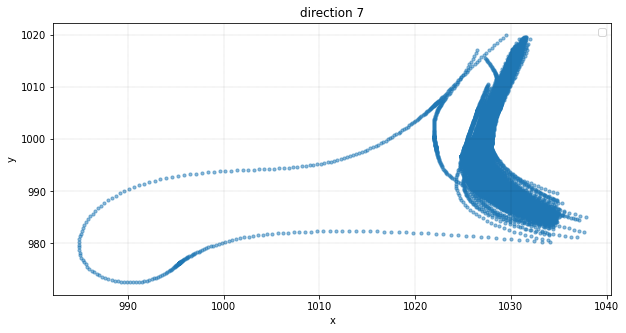

In [4]:
direction = 7

fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
df_ind = df[(df['direction'] == direction)]
# ax.plot(df_dire['X'][ind], df_dire['Y'][ind], color=colors[ind], label ='traj:'+str(ind), linewidth = 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('direction ' + str(direction))
ax.grid(color='k', linestyle='--', linewidth=0.1)
ax.scatter(df_ind['x'], df_ind['y'], alpha = 0.5, s=10)
ax.legend()

**let's discretize the direction into discr^2 rectangle and compute 3 matrices of dimensions (discr X discr):**
    * mean_speed: contains the average speeds for each rectangle.
    * mean_acc: contains the average accelerations for each rectangle.
    * mean_vehic: contains the number of vehicles passing through each rectangle.

In [5]:

discr = 50

df_dir = df[df['direction'] == direction]


min_x = df_dir.min(axis = 0)['x']
max_x = df_dir.max(axis = 0)['x']
dx = (max_x-min_x)/discr

min_y = df_dir.min(axis = 0)['y']
max_y = df_dir.max(axis = 0)['y']
dy = (max_y-min_y)/discr

data = []
mean_speed = np.zeros((discr,discr))
mean_acc = np.zeros((discr,discr))
mean_vehic = np.zeros((discr,discr))


for i in range(discr):
    load = round((100*(i+1)/discr), 2)
    sys.stdout.write('\rloading ' + str(load) + '%')
    sys.stdout.flush()
    for j in range(discr):
        df_dx_dy = df_dir[(df_dir['x'] >= min_x + i*dx) & (df_dir['x'] <= min_x + (i+1)*dx) 
                        & (df_dir['y'] >= min_y + j*dy) & (df_dir['y'] <= min_y + (j+1)*dy)]
        v_mean = (df_dx_dy.mean(axis = 0)['v'])
        a_mean = (df_dx_dy.mean(axis = 0)['a'])
        nb_vehicle = len(df_dx_dy.track_id.unique())
        data.append([min_x+i*dx, min_y+j*dy, v_mean, a_mean, nb_vehicle])
        mean_speed[i, j] = v_mean
        mean_acc[i, j] = a_mean
        mean_vehic[i, j] = nb_vehicle

mean_vehic[mean_vehic == 0] = np.nan

        
df_discr = pd.DataFrame(data, columns=['x', 'y', 'v_mean', 'a_mean', 'nb_vehicle'])
df_discr = df_discr.dropna()
df_discr = df_discr.reset_index(drop=True)



loading 100.0%

**by ploting the matrices, we can see that the speed and acceleration decrease at the beginnig of the turn and increase at the end**

Text(0.5, 1.05, 'number of vehicle by rectangle')

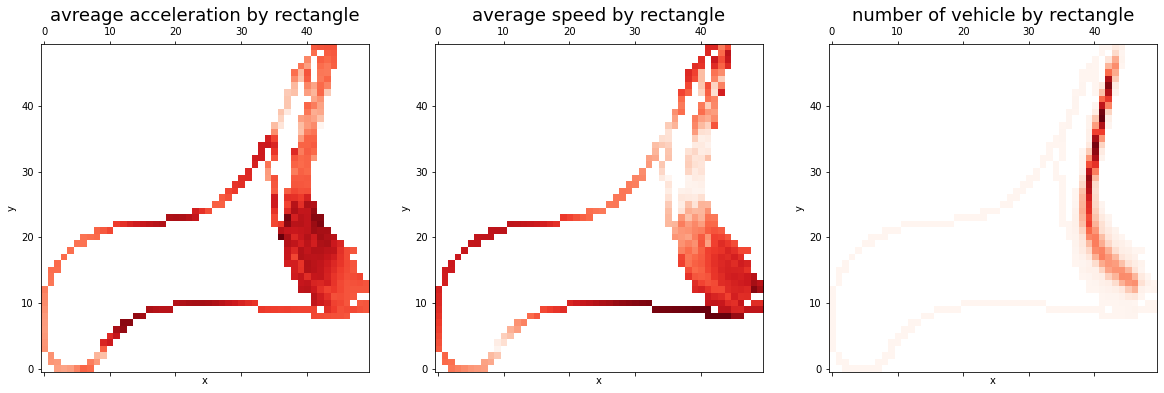

In [6]:
fig = plt.figure(figsize = (20, 10))

ax = fig.add_subplot(1, 3, 1)
ax.matshow(mean_acc.T, cmap=plt.cm.Reds, origin="lower")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('avreage acceleration by rectangle', fontsize=18, )

ax = fig.add_subplot(1, 3, 2)
ax.matshow(mean_speed.T, cmap=plt.cm.Reds, origin="lower")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('average speed by rectangle', fontsize=18)

ax = fig.add_subplot(1, 3, 3)
ax.matshow(mean_vehic.T, cmap=plt.cm.Reds, origin="lower")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('number of vehicle by rectangle', fontsize=18)

**We create df_spec_traj, the data frame containing the track_id of the vehicles which are the only ones to have passed through certain rectangle, and the number of times they have passed alone through rectangles.**

In [7]:
df_discr1 = df_discr[df_discr['nb_vehicle'] <= 1]

track_ids_1_vehicle = []
k = 0 
for ind in df_discr1.index:
    k += 1
    load = round( (k/len(df_discr1))*100, 2)
#     sys.stdout.write('\rloading ' + str(load) + '%')
#     sys.stdout.flush()
    x_min = round(df_discr1['x'][ind],20)
    x_max = round(df_discr1['x'][ind] + dx, 20)

    y_min = round(df_discr1['y'][ind], 20)
    y_max = round(df_discr1['y'][ind] + dy, 20)

    sys.stdout.write('\rloading ' + str(load) + '% ')
    sys.stdout.flush()
   
    nb_vehicle = (df_dir[(df_dir['x']>x_min) & (df_dir['x']<x_max) & (df_dir['y']>y_min) & (df_dir['y']<y_max)]).track_id.unique()
    
    if (nb_vehicle):
        track_ids_1_vehicle.append((int(nb_vehicle[0])))


data = {x:track_ids_1_vehicle.count(x) for x in track_ids_1_vehicle}
df_spec_traj = pd.DataFrame.from_dict(data, orient='index', columns=[ 'nb of alone rectangles']).sort_values(by='nb of alone rectangles', ascending=False)
df_spec_traj = df_spec_traj.reset_index()
df_spec_traj = df_spec_traj.rename(columns={"index": "track_id"})


loading 100.0% 

In [8]:
df_spec_traj.head()

,track_id,nb of alone rectangles
0,10109,121
1,4126,21
2,1696,11
3,77,4
4,9501,4


**we can see that track_id 10109 has a lot of rectangle where it's alone, it's certainly the abnormal trajectory**

In [9]:
def get_original_id(track_id, df_equi):
    original_id = int(df_equi[df_equi['new id'] == track_id]['original id'])
    csv = int(df_equi[df_equi['new id'] == track_id]['csv'])
    return csv, original_id

**the get_oginal_id function allows us to find the original csv and track id of the vehicle**

In [10]:
track_id = 4126
csv, original_id = get_original_id(track_id, df_equi)
print('csv:', csv, ',  track_id:', original_id)

csv: 21 ,  track_id: 70


**We can use the interaction data set tool to visualize the behaviour of this vehicle.**

then we create df_low_acc and df_low_speed, data frames that detect when the acceleration and speed are below a certain threshold value, this threshold value depends on the average acceleration/speed of the rectangle on which the vehicle is located.

df_low_acc contains:
* the track_id of the vehicle.
* the acceleration of the vehicle when it is below a certain threshold value.
* the average acceleration on each series of rectangle where the track_id appears with a low acceleration.
* the difference between the vehicle acceleration and the average acceleration.
* the first moment when the acceleration is below the threshold value.
* the last moment when the acceleration is below the threshold value

df_low_speed contains the same parameters for speed.

speed_rate and acc_rate vary the threshold values.
the higher the speed_rate and acc_rate, the higher the diff_v and diff_acc will be. 




In [11]:
mean_speed = np.nan_to_num(mean_speed)
mean_acc = np.nan_to_num(mean_acc)

speed_rate = 0.2
acc_rate = 0.5

data_low_speed = []
data_low_acc = []

for ind in df_dir.index:
    x = df_dir['x'][ind]
    y = df_dir['y'][ind]
    t = df_dir['timestamp_ms'][ind]
    v = df_dir['v'][ind]
    a = df_dir['a'][ind]
    track_id = df_dir['track_id'][ind]
    i = int((x-min_x)/dx)
    j = int((y-min_y)/dy)
    delta_acc = np.amax(mean_acc) - np.amin(mean_acc)
    delta_speed = np.amax(mean_speed) - np.amin(mean_speed)

    
    if i != discr and j != discr:
        v_mean = mean_speed[i, j]
        a_mean = mean_acc[i, j]
        inf_v = v_mean - speed_rate*delta_speed
        inf_a = a_mean - acc_rate*delta_acc
        if v<inf_v :
            data_low_speed.append([track_id, v, v_mean, t])
        if a<inf_a:
            data_low_acc.append([track_id, a, a_mean, t])


df_low_speed = pd.DataFrame(data_low_speed, columns=['track_id', 'v', 'v_mean', 't'])
df_low_acc = pd.DataFrame(data_low_acc, columns=['track_id', 'a', 'a_mean', 't'])


tracks_speed = df_low_speed['track_id'].unique()
data = []
for track in tracks_speed:
    df_track = df_low_speed[df_low_speed['track_id'] == track]
    t_min = df_track.min(axis = 0)['t']
    t_max = df_track.max(axis = 0)['t']
    v = df_track.mean(axis = 0)['v']
    mean_v = df_track.mean(axis = 0)['v_mean']
    data.append([track, v, mean_v, mean_v-v, t_min, t_max])
df_low_speed = pd.DataFrame(data, columns=['track_id', 'v','v_mean', 'diff_v', 't_min', 't_max'])
df_low_speed = df_low_speed.sort_values(by='diff_v', ascending=False)

tracks_acc = df_low_acc['track_id'].unique()
data = []
for track in tracks_acc:
    df_track = df_low_acc[df_low_acc['track_id'] == track]
    t_min = df_track.min(axis = 0)['t']
    t_max = df_track.max(axis = 0)['t']
    a = df_track.mean(axis = 0)['a']
    mean_a = df_track.mean(axis = 0)['a_mean']
    data.append([track, a, mean_a, mean_a-a, t_min, t_max])
df_low_acc = pd.DataFrame(data, columns=['track_id', 'a', 'a_mean', 'diff_a', 't_min', 't_max'])
df_low_acc = df_low_acc.sort_values(by='diff_a', ascending=False)


In [12]:
df_low_acc.head()

,track_id,a,a_mean,diff_a,t_min,t_max
1,649.0,-0.003944,-0.000337,0.003606,186500.0,188100.0
27,6268.0,-0.003299,-0.000206,0.003093,146000.0,147400.0
10,2902.0,-0.003440,-0.000491,0.002949,2100.0,3400.0
8,2479.0,-0.003108,-0.000222,0.002886,193200.0,194300.0
6,1696.0,-0.001885,0.000911,0.002795,92900.0,94000.0


In [13]:
df_low_speed.head()

,track_id,v,v_mean,diff_v,t_min,t_max
10,1484.0,0.692540,3.827582,3.135042,74500.0,80200.0
6,1315.0,0.548963,3.682761,3.133798,131600.0,196000.0
37,9413.0,0.972087,3.959867,2.987779,131900.0,143700.0
39,9470.0,0.427678,3.393184,2.965506,188500.0,192800.0
38,9458.0,0.349895,2.976764,2.626869,184900.0,190700.0


In [14]:
track_id = 1484.0
csv, original_id = get_original_id(track_id, df_equi)
print('csv:', csv, ',  track_id:', original_id)

csv: 7 ,  track_id: 61


**here we can also use the interaction data set tool to visualize the behaviour of these vehicles betwin t_min and t_max.**